In [579]:
import random
import numpy as np
import math
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

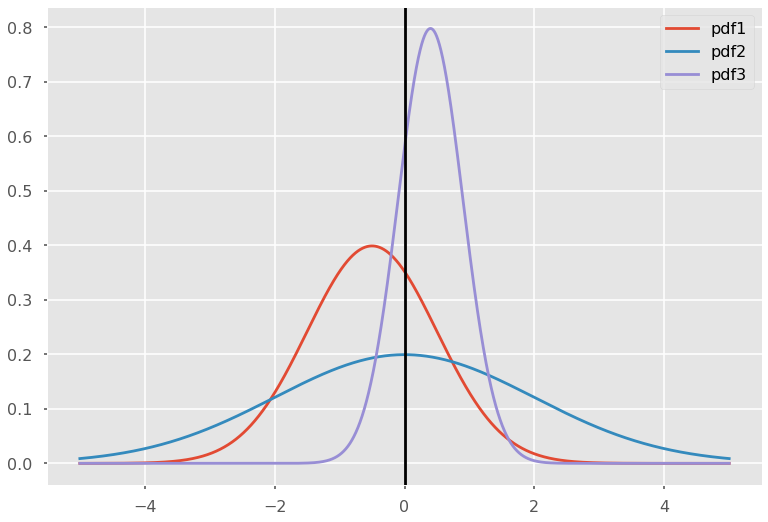

In [64]:
x = np.linspace(-5, 5, 5000)
mu = 0
sigma = 1

# y_pdf = stats.norm.pdf(x, mu, sigma)
y_pdf1 = stats.norm.pdf(x, -0.5, 1)
# y_pdf2 = stats.norm.pdf(x, 0, 1.2)
y_pdf2 = stats.norm.pdf(x, 0, 2)
y_pdf3 = stats.norm.pdf(x, 0.4, 0.5)

plt.plot(x, y_pdf1, label='pdf1')
plt.plot(x, y_pdf2, label='pdf2')
plt.plot(x, y_pdf3, label='pdf3')
plt.axvline(x=0, color='black', linestyle='-')
plt.legend()

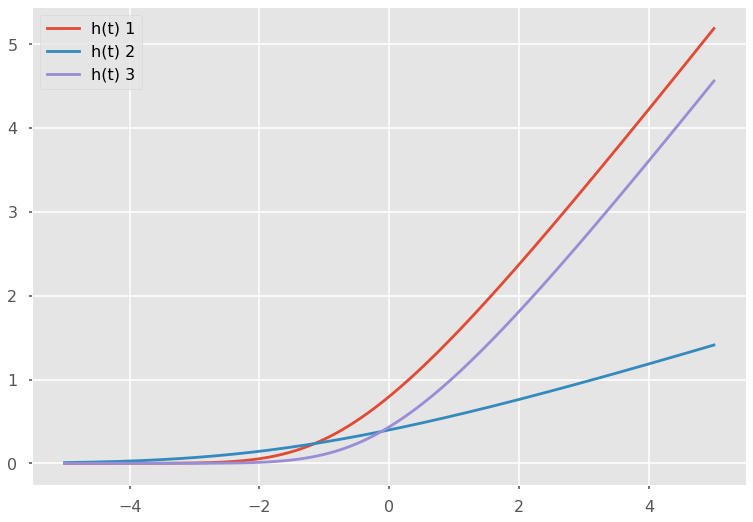

In [65]:
x = np.linspace(-5, 5, 5000)

# y_pdf = stats.norm.pdf(x, mu, sigma)
y_pdf1 = stats.norm.pdf(x, 0, 1)
y_sf1 = stats.norm.sf(x, 0, 1)
y_pdf2 = stats.norm.pdf(x, 0, 2)
y_sf2 = stats.norm.sf(x, 0, 2)
y_pdf3 = stats.norm.pdf(x, 0.65, 1)
y_sf3 = stats.norm.sf(x, 0.65, 1)

h1 = [f/s for f, s in zip(y_pdf1, y_sf1)]
h2 = [f/s for f, s in zip(y_pdf2, y_sf2)]
h3 = [f/s for f, s in zip(y_pdf3, y_sf3)]

plt.plot(x, h1, label='h(t) 1')
plt.plot(x, h2, label='h(t) 2')
plt.plot(x, h3, label='h(t) 3')
plt.legend()

In [451]:
# Node for each hs and counter, see the flipflop between
min_time = -10
time_points = np.linspace(min_time, 10, 800)
delta = time_points[1] - time_points[0]
class Node:
    def __init__(self, uid, hazard, goal, c=1.0):
        self.uid = uid
        self.c = c
        self.index = 0
        self.hazard = hazard
        self.goal = goal
        self.min_steps = int(round((self.goal - min_time) / delta))
        
    def reset(self):
        self.index = 0
        
    def minSteps(self):
        return self.min_steps
        
    def cost(self):
#         return ((self.index + 1) * self.c) / self.hazard[self.index]
        return self.hazard[self.index] / ((self.index + 1)**2 * self.c)
#         return self.hazard[self.index] / ((self.index + 1) * self.c)
    
    def isGoal(self):
        return time_points[self.index] >= self.goal
    
    def expand(self):
        self.index += 1
        
    def getUID(self):
        return self.uid
    
    def getIndex(self):
        return self.index
        
    def __str__(self):
        return 'uid={}\t idx={:5d}\t hazard={:8.3f}\t cost={:10.5f}\t t={:8.5f}\t goal={:7.5f}\t min_steps={:d}, '.format(
            self.uid, self.index, self.hazard[self.index], self.cost(), time_points[self.index], self.goal, self.min_steps
        )

In [357]:
def printVerb(msg, verb):
    if verb:
        print(msg)

def LevinTS(nodes, verbose=True):
    best_time = min(nodes, key=lambda x : x.minSteps()).minSteps()
    printVerb('Best possible time: {}'.format(best_time), verbose)
    printVerb('Nodes:', verbose)
    for node in nodes:
        printVerb(node, verbose)

    current_node = None
    node_history = []
    counter = 0
    while True:
        min_node = max(nodes, key=lambda x : x.cost())
        min_node.expand()
        counter += 1

        # Node swap
        if len(node_history) == 0 or node_history[-1][0] != min_node.getUID():
            node_history.append((min_node.getUID(), str(min_node)))

        if min_node.isGoal():
            global_efficiency = best_time / counter
            local_efficiency = min_node.getIndex() / counter
            printVerb('', verbose)
            printVerb('Found solution at global step: {}'.format(counter), verbose)
            printVerb('Global efficiency: {:.4f}'.format(global_efficiency), verbose)
            printVerb('Local efficiency: {:.4f}'.format(local_efficiency), verbose)
            printVerb(min_node, verbose)
            
            return global_efficiency, local_efficiency, node_history

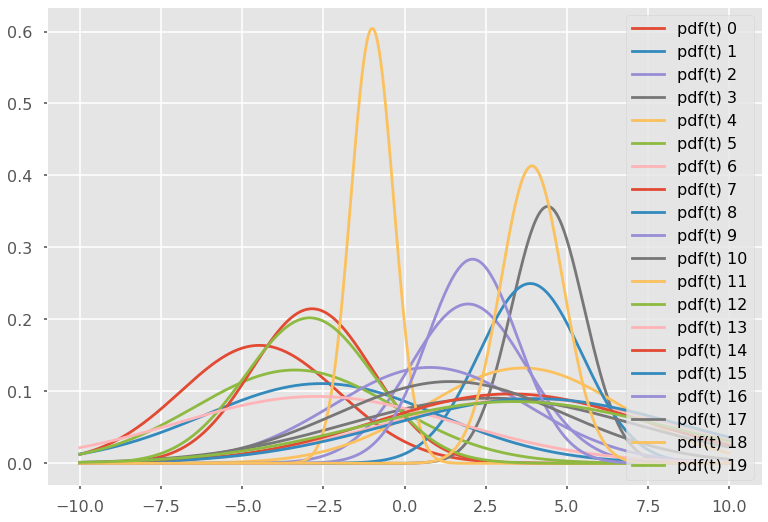

In [605]:
epsilon = 1e-8
NUM_INSTANCES = 20
# mus = [2*random.uniform(0,1) for _ in range(NUM_INSTANCES)]
mus = [random.choice(time_points) / 2 for _ in range(NUM_INSTANCES)]
sigmas = [5*(random.uniform(0,1) + epsilon) / 1 for _ in range(NUM_INSTANCES)]
# sigmas = [1 for _ in range(NUM_INSTANCES)]
pdfs = [stats.norm.pdf(time_points, m, s) for m, s in zip(mus, sigmas)]
sfs = [stats.norm.sf(time_points, m, s) for m, s in zip(mus, sigmas)]
hs = []
for pdf, sf in zip(pdfs, sfs):
    hs.append([np.exp(np.log(f) - np.log(s)) if s == 0 else f/s for f, s in zip(pdf, sf)])
# hs = [[np.exp(np.log(f) - np.log(s)) for f, s in zip(pdf, sf)] for (pdf, sf) in zip(pdfs, sfs)]
for i, pdf in enumerate(pdfs):
    plt.plot(time_points, pdf, label='pdf(t) {}'.format(i))
plt.legend()

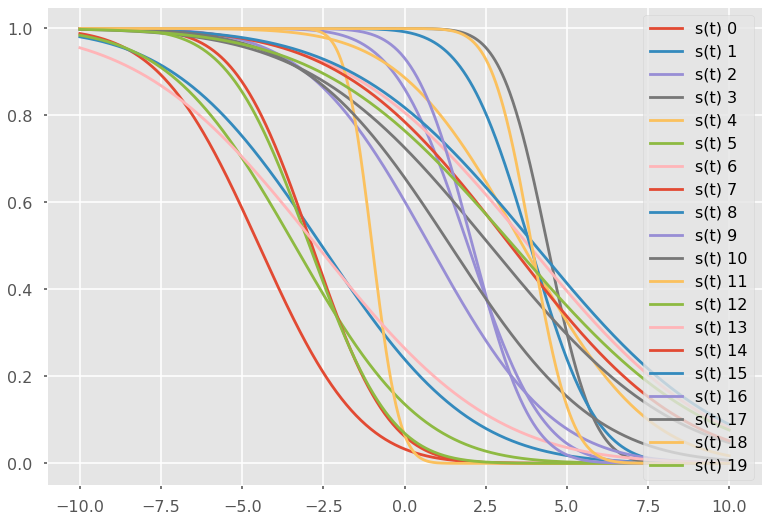

In [606]:
for i, s in enumerate(sfs):
    plt.plot(time_points, s, label='s(t) {}'.format(i))
plt.legend()

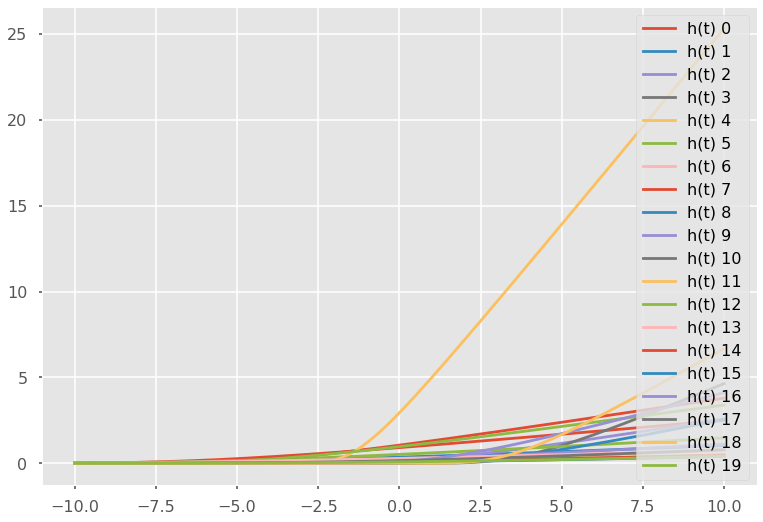

In [607]:
for i, h in enumerate(hs):
    plt.plot(time_points, h, label='h(t) {}'.format(i))
plt.legend()

In [608]:
global_efficiencies = []
local_efficiencies = []
verbose = True
for _ in range(1):
    goals = [np.random.randn() * s + m for m, s in zip(mus, sigmas)]
    goals = [m/s for m, s in zip(mus, sigmas)]
    nodes = [Node(i, h, g, 1) for i, (h, g) in enumerate(zip(hs, goals))]
    global_efficiency, local_efficiency, node_history = LevinTS(nodes, verbose=verbose)
    global_efficiencies.append(global_efficiency)
    local_efficiencies.append(local_efficiency)
    if verbose:
        print('-----------------------')
        print('Open list history of swaps')
        for node in node_history:
            print(node[1])

global_avg = sum(global_efficiencies) / len(global_efficiencies)
local_avg = sum(local_efficiencies) / len(local_efficiencies)
print('Average global efficiency: {}'.format(global_avg))
print('Average local efficiency: {}'.format(local_avg))

Best possible time: 326
Nodes:
uid=0	 idx=    0	 hazard=   0.013	 cost=   0.01259	 t=-10.00000	 goal=-1.83860	 min_steps=326, 
uid=1	 idx=    0	 hazard=   0.013	 cost=   0.01323	 t=-10.00000	 goal=-0.70778	 min_steps=371, 
uid=2	 idx=    0	 hazard=   0.000	 cost=   0.00000	 t=-10.00000	 goal=1.08724	 min_steps=443, 
uid=3	 idx=    0	 hazard=   0.000	 cost=   0.00000	 t=-10.00000	 goal=3.94780	 min_steps=557, 
uid=4	 idx=    0	 hazard=   0.000	 cost=   0.00000	 t=-10.00000	 goal=1.21185	 min_steps=448, 
uid=5	 idx=    0	 hazard=   0.013	 cost=   0.01294	 t=-10.00000	 goal=-1.09657	 min_steps=356, 
uid=6	 idx=    0	 hazard=   0.001	 cost=   0.00068	 t=-10.00000	 goal=0.86663	 min_steps=434, 
uid=7	 idx=    0	 hazard=   0.000	 cost=   0.00013	 t=-10.00000	 goal=-1.53300	 min_steps=338, 
uid=8	 idx=    0	 hazard=   0.000	 cost=   0.00000	 t=-10.00000	 goal=2.42601	 min_steps=496, 
uid=9	 idx=    0	 hazard=   0.000	 cost=   0.00020	 t=-10.00000	 goal=0.26137	 min_steps=410, 
uid=10	 idx=   